In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys

SCRIPT_DIR = Path('/home/alina.smolina/DL-pipeline/src')
sys.path.append(str(SCRIPT_DIR))
from module import SegModule

In [3]:
import torch
import time
import glob
torch.set_float32_matmul_precision('high')

import wandb
import pytorch_lightning as pl

In [4]:
def split_img(img, patch_height, patch_width, overlap):
    
    max_height, max_width, num_bands = img.shape
    
    height_ind = 0
    height = 0
    imgarr = []

    while height < max_height:
        width_ind = 0
        width = 0
        while width < max_width:
            tmp = np.zeros((patch_height, patch_width, num_bands), dtype=int)
            
            tmp1_end_vertical = min(height + patch_height, max_height)
            tmp1_end_horizontal = min(width + patch_width, max_width)
            tmp1 = img[height:tmp1_end_vertical, width:tmp1_end_horizontal]
            tmp1_height, tmp1_width, _ = tmp1.shape
            
            tmp[:tmp1_height, :tmp1_width, :] = tmp1
            
            pad_width = tmp.shape[1] - tmp1_width
            pad_height = tmp.shape[0] - tmp1_height
            
            padded_tensor = np.pad(
                 tmp1, 
                 ((0, pad_height), (0, pad_width), (0, 0)), 
                 'reflect',
                 )

            imgarr.append(padded_tensor)

            width_ind += 1
            width += patch_width - 2 * overlap

        height += patch_height - 2 * overlap
        height_ind += 1
        
    return np.asarray(imgarr), height_ind, width_ind



def reconstruct_pred(pred, 
                     size_x, 
                     size_y, 
                     patch_height, 
                     patch_width, 
                     overlap, 
                     height_ind, 
                     width_ind,
                     no_data_value = -1,
                    ):
    # pred.shape = (#pathces, patch_height, patch_width, channels_out)
    # recon.shape = (height, width, channels_out)
    recon = np.ones((size_x, size_y, pred.shape[-1]), pred.dtype) * no_data_value
    final_patch = patch_height - overlap
    small_flag_y = (size_y < patch_width)

    for i in range(height_ind):
        for j in range(width_ind):
            a0 = overlap * (i != 0)
            a1 = -max(overlap, final_patch - (size_x - (i != 0) * (final_patch + (i - 1) * (patch_height - 2 * overlap))))
            
            b0 = overlap * (j != 0)
            b1 = -small_flag_y - max(overlap, final_patch - (size_y - (j != 0) * (final_patch + (j - 1) * (patch_width - 2 * overlap))))
            
            out = pred[i * width_ind + j][a0:a1, b0:b1, :]
            recon[
                (i != 0) * (final_patch + (i - 1) * (patch_height - 2 * overlap)):min(
                    final_patch + i * (patch_height - 2 * overlap), 
                    size_x
                    ),
                (j != 0) * (final_patch + (j - 1) * (patch_width - 2 * overlap)): min(
                    final_patch + j * (patch_width - 2 * overlap), 
                    size_y), 
                    :
                    ] = out
    return recon


In [5]:
import matplotlib.pyplot as plt
from rasterio.windows import Window
import pandas as pd
import rasterio
import numpy as np
from rasterio.plot import show_hist
from pprint import pprint

### Korsak
# Get table with types and ages
# Target map shape is: (h, w) = (12775, 6965)

### Nevelsk
# Get table with types and ages
# Target map shape is: (h, w) = (10461, 2379)
#### -------------------------------> [x]
####|          ____________
####|         |            |
####|         |   TRAIN    |
####|         |            |
####|   (0, a).____________.(w, a)
####|         |            |
####|         |    TEST    |
####|         |            |
####|   (h, a).____________.(w, h)
####|
####|
####\/ [y]




def get_data(channels_list, path, window=None, get_stat=False):
    channels = []
    for ch in channels_list:
        with rasterio.open(f'{path}/{ch}.tif') as src:
            if window is None:
                channels += [src.read(1)]
            else:
                channels += [src.read(1, window=window)]

    multispectral_img = np.stack(channels)
    print(f'🪄: shape of the resulting tensor is {multispectral_img.shape}')
    
    band_stats = {}
    
    if get_stat:
        
        flattened_multispectral_img = multispectral_img.reshape(multispectral_img.shape[0], -1)
        maximums = np.max(flattened_multispectral_img, axis=-1)
        minimums = np.min(flattened_multispectral_img, axis=-1)
        means = np.mean(flattened_multispectral_img, axis=-1)
        stds = np.std(flattened_multispectral_img, axis=-1)
        percentiles_99 = np.percentile(flattened_multispectral_img, q=99, axis=-1)
        percentiles_1 = np.percentile(flattened_multispectral_img, q=1, axis=-1)
        for i, ch in enumerate(channels_list):
            band_stats[ch] = {'min': minimums[i], 
                              'max': maximums[i], 
                              'mean': means[i], 
                              'std': stds[i],
                              'percentile_99': percentiles_99[i],
                              'percentile_1': percentiles_1[i],
                             }
        
        fig, axes = plt.subplots(1, 3, figsize=(40, 10))
        show_hist(multispectral_img, bins=1000, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram", ax=axes[0])
        show_hist(multispectral_img, bins=1000, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram (log scale)", log=True, ax=axes[1])
        show_hist(np.log(multispectral_img), bins=1000, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="log-transform Histogram", ax=axes[2])
        plt.show()
        
    return multispectral_img, band_stats

In [27]:
# архангельские данные
channels_list = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
images_dir = './../../data/arkhangelsk/tile_UTM38N/20180406'

y0, x0 = 6000, 0
train_window = Window.from_slices((y0, y0 + 4000), (x0, x0 + 2700))

# сахалин - невельск - тестовое окно
# h, w = 10461, 2379
# a = 8000
# y0, x0 = a, 0
# test_window = Window.from_slices((y0, h), (x0, x0 + w))
images_inference_dir = './../data/images/nevelsk/20180423'
test_window = None

# # # трубопровод
# images_inference_dir = './../data/images/iki2/20180416'
# test_window = None

🪄: shape of the resulting tensor is (10, 3450, 2700)


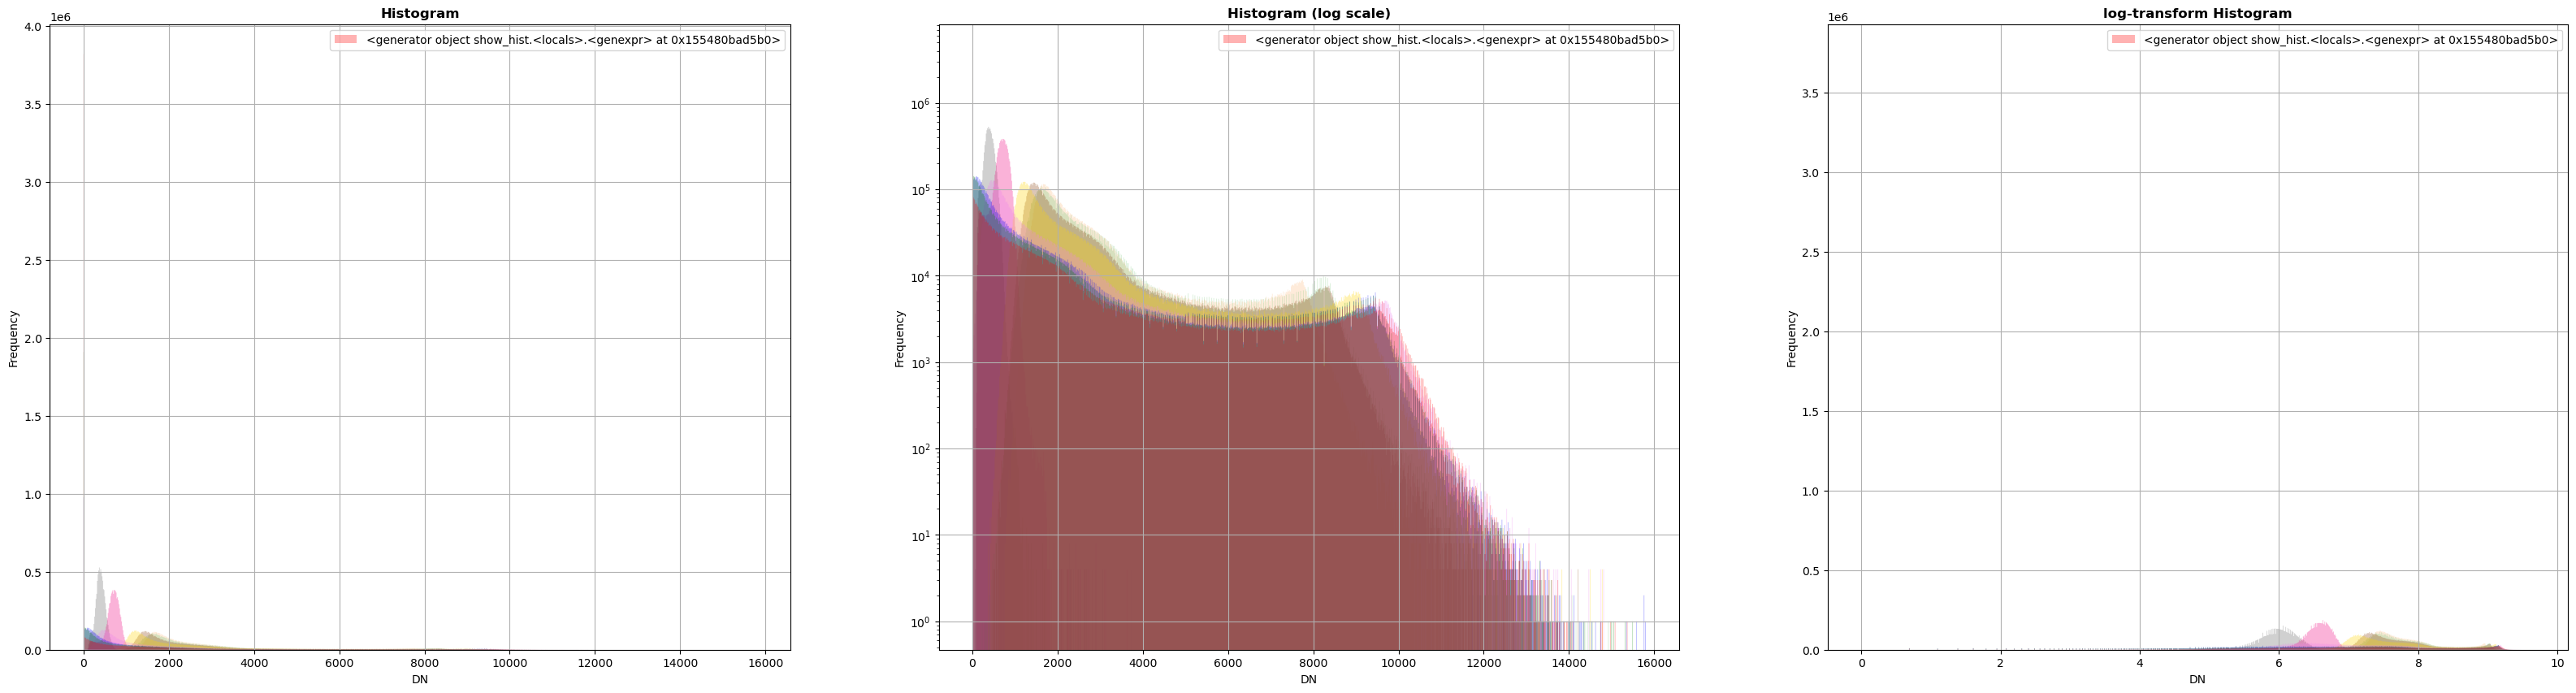

🪄: shape of the resulting tensor is (10, 10461, 2379)


In [28]:
X_train, band_stats_train = get_data(channels_list, images_dir, window=train_window, get_stat=True)

X_predict, _ = get_data(channels_list, images_inference_dir, window=test_window, get_stat=False)

In [35]:
patch_height = 128
patch_width = 128
overlap = 32 # 32
_, out_height, out_width = X_predict.shape
out, height_ind, width_ind = split_img(
    np.transpose(X_predict, (1, 2, 0)), 
    patch_height, 
    patch_width, 
    overlap,
)

In [30]:
model = SegModule.load_from_checkpoint(
    '/beegfs/home/alina.smolina/DL-pipeline/weights/group-2classes-archangelsk/solar-water-12/epoch=369-val_loss=0.00.ckpt',
    # "/beegfs/home/alina.smolina/DL-pipeline/weights/group-2classes-archangelsk/fresh-galaxy-4/epoch=419-val_loss=0.00.ckpt",
    map_location=torch.device('cpu'),
)
model.eval() # disable randomness, dropout, etc...
print('🤖: Model initialized')

🤖: Model initialized


In [31]:
import torch
torch.cuda.is_available()

True

In [36]:
from datamodule import GeoModule

one_date = GeoModule(
    X_train, 
    X_train, 
    X_train, 
    X_train,
    X_train,
    X_train,
    transform=None,
    batch_size=64,
    patch_size=128, #512,
    stride=64, # 512,
    norm_strategy='min_max',
    num_workers=24, 
    X_predict=X_predict,
)

In [37]:
trainer = pl.Trainer(accelerator="gpu", devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
out = trainer.predict(model, datamodule=one_date)

🤖: Setup data...
🤖: percentile_99 = [9728. 9520. 9504. 9789. 9178. 8502. 8520. 7911. 1020.  681.]
🤖: percentile_1 = [1.000e+00 1.000e+00 1.000e+00 1.850e+02 8.750e+02 1.088e+03 1.158e+03
 1.306e+03 1.590e+02 1.380e+02]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🤖: #iterations in predict dataloader: 98


Predicting: 0it [00:00, ?it/s]

In [39]:
print(len(out))
print(out[0].size())

98
torch.Size([64, 2, 128, 128])


In [40]:
predict_all = []
for res_iteration in out:
    pred_mask = torch.argmax(res_iteration, dim=1, keepdim=True)
    predict_all.append(pred_mask.numpy(force=True))

In [41]:
len(predict_all)

98

In [17]:
predict_all[-2].shape

(64, 1, 128, 128)

In [18]:
np.concatenate(predict_all).shape

(8424, 1, 128, 128)

In [19]:
overlap

1

In [42]:
res_recon = reconstruct_pred(
    np.transpose(np.concatenate(predict_all), (0, 2, 3, 1)), 
    out_height, 
    out_width, 
    patch_height, 
    patch_width, 
    overlap, 
    height_ind, 
    width_ind,
                            )

res = np.squeeze(res_recon)

In [43]:
res.shape #6601 4405

(10461, 2379)

In [44]:
np.unique(res)

array([0, 1])

In [45]:
def get_profile(reference_tif_path, crop_window=None):
    with rasterio.open(reference_tif_path) as src:
        profile = src.meta.copy()
        
        if crop_window is None:
            crop = src.read(1)
            out_transform = src.transform
        else: 
            crop = src.read(1, window=crop_window)
            out_transform = src.window_transform(crop_window)
    
        profile.update(
            {
                "driver": 'GTiff',
                "height": crop.shape[0],
                "width": crop.shape[1],
                "transform": out_transform,
            }
        )
    return profile, crop


def save_tif(img, profile, out_path):
    with rasterio.open(out_path, 'w', **profile) as dst: 
        dst.write(img, indexes=1)
        dst.close()

In [47]:
profile, crop = get_profile(f'{images_inference_dir}/{channels_list[0]}.tif', crop_window=test_window)

In [48]:
save_tif(res, profile, f'{images_inference_dir}/solar-water-12-2group-pred-stride-32.tif')

In [49]:
images_inference_dir

'./../data/images/nevelsk/20180423'